# Data Analysis Chatbot

In [137]:

import pandas as pd
import json
from transformers import BertTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from pylab import rcParams
import tensorflow as tf
# import tensorflow_text
import tensorflow_hub as hub
import tensorflow_text as text
import keras_nlp
tf.config.run_functions_eagerly(True)


In [138]:
tf.get_logger().setLevel('ERROR')

sns.set_theme(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
import warnings
warnings.filterwarnings("ignore")

In [139]:
train_file="intent.json"
test_file="test.json"

## Data Pre processing and Feature Extraction.

In [155]:
from sklearn.model_selection import train_test_split
with open(train_file) as f:
    data = json.load(f)

intent_df=pd.DataFrame(data['intents'])

intent_df=intent_df[['intent','patterns']].explode('patterns')

train_df, valid_df = train_test_split(intent_df, test_size=0.2, random_state=42)

train_df.head()

,intent,patterns
8,GeneratePieChart,Create a pie chart showing product category di...
9,GenerateScatterPlot,Show correlation between product price and cus...
11,GenerateHistogram,I need a histogram showing distribution of cus...
3,TimeBasedAnalysis,Show me a breakdown of sales by week for the p...
8,GeneratePieChart,Show market share by product category using a ...


In [156]:
train_df.shape

(189, 2)

In [157]:
with open(test_file) as f:
    data = json.load(f)
test_df=pd.DataFrame(data['intents'])
test_df=test_df.explode('patterns')
test_df.head()

,intent,patterns
0,GetTransactionDetails,What are the specifics for InvoiceNo 123456?
0,GetTransactionDetails,Can you provide information on InvoiceNo 123456?
0,GetTransactionDetails,Give me the details of transaction InvoiceNo 1...
0,GetTransactionDetails,"Details for InvoiceNo 123456, please?"
0,GetTransactionDetails,How much was spent on InvoiceNo 123456?


In [158]:
train_features=train_df.copy()
train_labels=pd.DataFrame(train_features.pop('intent'))



In [159]:
train_features=train_features.values



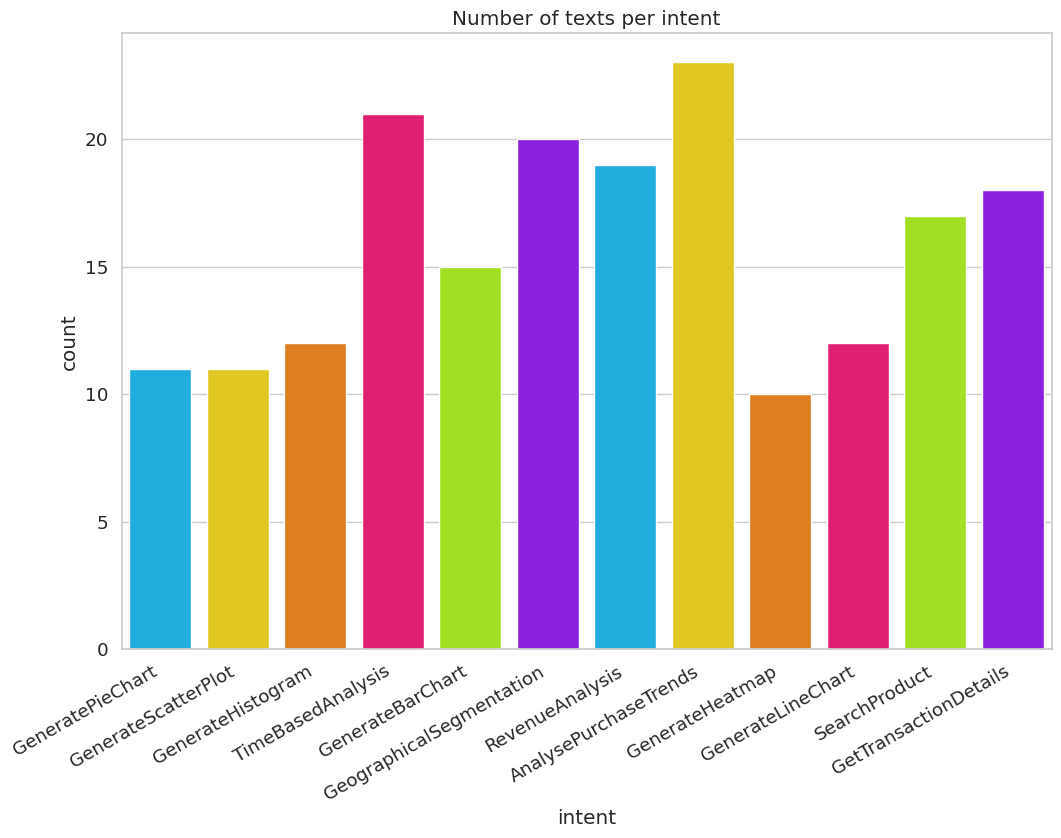

In [160]:
chart = sns.countplot(train_labels, palette=HAPPY_COLORS_PALETTE,x="intent")
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

### One Hot Encode labels

In [161]:
binarizer=LabelBinarizer()
train_labels=binarizer.fit_transform(train_labels.values)


In [162]:
train_labels.shape


(189, 12)

In [163]:
test_features=test_df.copy()
test_labels=test_features.pop("intent")

valid_features=valid_df.copy()
valid_labels=valid_features.pop("intent")

test_features=test_features.values
valid_features=valid_features.values

test_labels=binarizer.transform(test_labels.values)
valid_labels=binarizer.transform(valid_labels.values)



## Loading models from TensorFlow Hub

In [164]:
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'
map_name_to_handle = {

    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'
}

map_model_to_preprocess = {

    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',

}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2


## Preprocessing Model

In [165]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [166]:
train_features[0]

array(['Create a pie chart showing product category distribution.'],
      dtype=object)

In [167]:
text_test = train_features[0]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  3443  1037 11345  3673  4760  4031  4696  4353  1012   102     0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


## BERT Model

In [168]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [169]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Pooled Outputs Shape:(1, 128)
Pooled Outputs Values:[-0.9999954  -0.02950013 -0.99695545  0.9843882  -0.98682016  0.96788067
 -0.8379424  -0.920943    0.07637723 -0.02310717 -0.6241363  -0.07763859]
Sequence Outputs Shape:(1, 128, 128)
Sequence Outputs Values:[[-0.7312873   0.06381935 -3.193368   ... -1.875363   -1.4363499
  -0.23915043]
 [-0.94437766  1.0409433  -0.00924829 ... -1.9613576  -2.0526514
   1.1615942 ]
 [-0.968965    0.84571123 -0.16618246 ... -2.290343   -1.5159055
  -0.05330684]
 ...
 [-0.02266759  0.788532   -0.07804063 ... -2.349465   -1.5821875
  -0.39166465]
 [-1.0768783   1.2205863   0.15117118 ... -2.3705392  -1.6676254
   0.19265915]
 [-0.6681377   1.076333   -0.07807219 ... -2.479541   -1.8854349
   0.11678502]]


## Define the Model

In [170]:
!pip install keras

In [171]:
# def build_classifier_model():
#     text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

#     # Preprocess input text using BertPreprocessor
#     preprocessing_layer = keras_nlp.models.BertPreprocessor.from_preset("bert_base_en_uncased", trainable=True)
#     encoder_inputs = preprocessing_layer(text_input)

#     # Get the BertBackbone model
#     encoder = keras_nlp.models.BertBackbone.from_preset("bert_base_en_uncased")

#     # Pass the preprocessed inputs through the backbone
#     outputs = encoder(encoder_inputs)
#     net = outputs['pooled_output']

#     # Additional layers for classification
#     net = tf.keras.layers.Dropout(0.1)(net)
#     net = tf.keras.layers.Dense(7, activation=None, name='classifier')(net)

#     return tf.keras.Model(text_input, net)

In [172]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)  # Increased dropout rate
  net = tf.keras.layers.Dense(12, activation=None, name='classifier')(net)  # Adjusted output size
  return tf.keras.Model(text_input, net)

In [173]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(train_features[0]))
print(tf.keras.activations.softmax(bert_raw_result))

tf.Tensor(
[[0.25237265 0.03391533 0.02584583 0.17311248 0.06524204 0.0310942
  0.01108348 0.0424834  0.17374308 0.04846893 0.04790781 0.09473064]], shape=(1, 12), dtype=float32)


In [174]:
classifier_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

## Model Training

In [175]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = [tf.metrics.CategoricalAccuracy()]
metrics

## Loading the BERT model and training

In [176]:
epochs=5
optimizer=tf.keras.optimizers.Adam(0.0005)
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)


In [177]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_features,y=train_labels,
                               validation_data=(valid_features,valid_labels),
                               batch_size=5,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/5
38/38 [==============================] - 21s 495ms/step - loss: 2.2611 - categorical_accuracy: 0.2804 - val_loss: 1.5425 - val_categorical_accuracy: 0.5208
Epoch 2/5
38/38 [==============================] - 24s 638ms/step - loss: 1.0422 - categorical_accuracy: 0.7249 - val_loss: 0.6433 - val_categorical_accuracy: 0.8125
Epoch 3/5
38/38 [==============================] - 17s 445ms/step - loss: 0.6314 - categorical_accuracy: 0.8042 - val_loss: 0.3382 - val_categorical_accuracy: 0.9375
Epoch 4/5
38/38 [==============================] - 12s 321ms/step - loss: 0.3656 - categorical_accuracy: 0.9153 - val_loss: 0.2787 - val_categorical_accuracy: 0.9375
Epoch 5/5
38/38 [==============================] - 12s 323ms/step - loss: 0.2768 - categorical_accuracy: 0.9312 - val_loss: 0.2683 - val_categorical_accuracy: 0.9167


In [178]:
loss, accuracy = classifier_model.evaluate(test_features,test_labels)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

3/3 [==============================] - 0s 88ms/step - loss: 0.0775 - categorical_accuracy: 0.9714
Loss: 0.07752855867147446
Accuracy: 0.9714285731315613


3/3 [==============================] - 0s 79ms/step


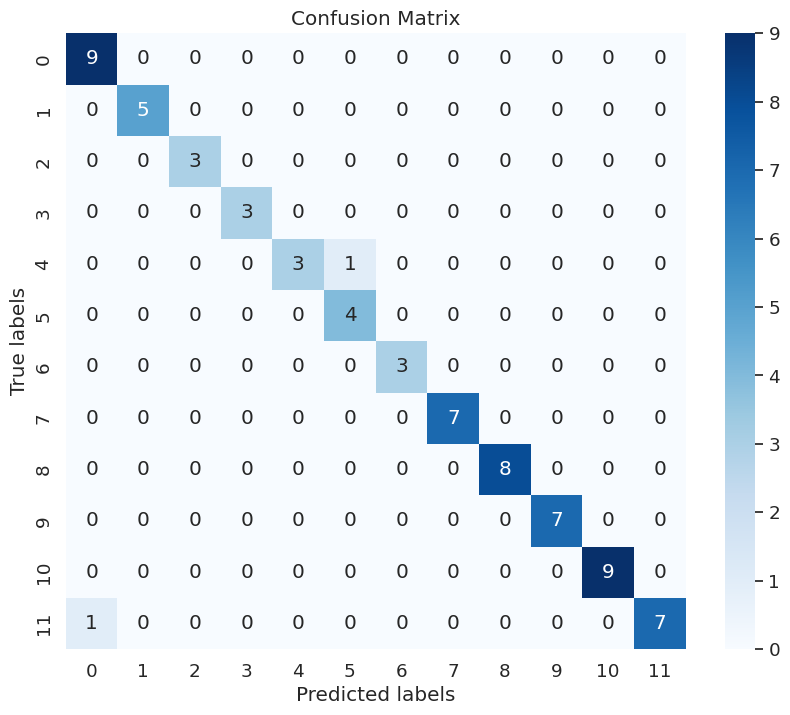

In [179]:
import numpy as np
from sklearn.metrics import confusion_matrix
# Get the predicted labels for the test data
predicted_labels = np.argmax(classifier_model.predict(test_features), axis=1)
# Convert one-hot encoded true labels back to categorical labels
true_labels = np.argmax(test_labels, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')  # Replace ... with your class labels
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [180]:
true_labels = np.argmax(test_labels, axis=1)

# Create a DataFrame to store the data
data = {'Pattern': test_df['patterns'],  # Assuming test_patterns contains the patterns for the test data
        'Actual': true_labels,
        'Predicted': predicted_labels}
df = pd.DataFrame(data)

# Display the DataFrame
df

,Pattern,Actual,Predicted
0,What are the specifics for InvoiceNo 123456?,8,8
0,Can you provide information on InvoiceNo 123456?,8,8
0,Give me the details of transaction InvoiceNo 1...,8,8
0,"Details for InvoiceNo 123456, please?",8,8
0,How much was spent on InvoiceNo 123456?,8,8
...,...,...,...
10,Show me a heatmap of customer satisfaction rat...,2,2
10,Create a heatmap showing customer engagement b...,2,2
11,I need a histogram showing distribution of ord...,3,3
11,Show me a histogram of customer ratings.,3,3


In [181]:
invoice_text = "Show me a heatmap of order by customer"


# Predict details based on preprocessed text
predicted_label = classifier_model.predict([invoice_text])

# Convert the predicted label to a human-readable format if necessary
# For example, if you have a list of class labels, you can get the predicted label's index and find the corresponding class label
# class_labels = ['Class 0', 'Class 1', 'Class 2', ...]  # Replace ... with your class labels
predicted_class_index = np.argmax(predicted_label)
# predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class label
print("Predicted class:", predicted_class_index)

1/1 [==============================] - 0s 58ms/step
Predicted class: 2


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


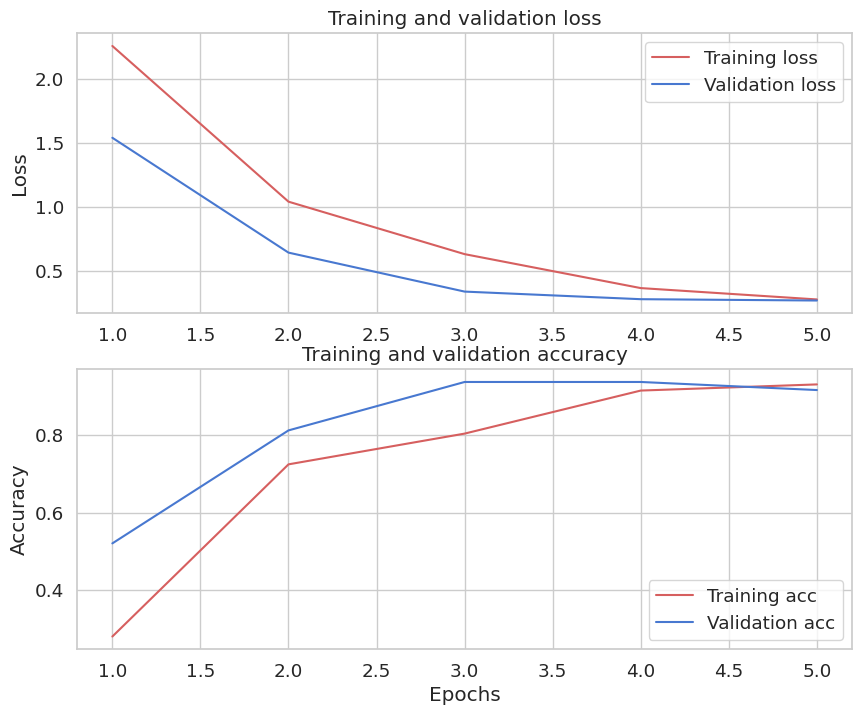

In [182]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 8))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid(True)
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')